In [3]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [4]:
to_pedix = str.maketrans("3", "₃")

In [5]:
import xarray as xr

nh3_nc = xr.load_dataset('../datasets/CAMS-GLOB-ANT_Glb_0.1x0.1_anthro_nh3_v4.2_monthly_lombardia.nc') # Copernicus (0.1°x0.1°)

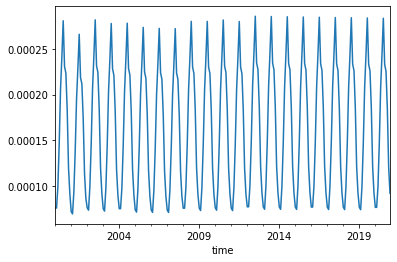

In [42]:
from utils import utils
import matplotlib.pyplot as plt

nh3 = utils.xarray2pandas(nh3_nc.agl, 6, 17).to_period('M')

nh3.plot()
plt.show()

In [64]:
import pandas as pd
import numpy as np

nh3 = pd.Series(nh3)

t = [i for i in range(len(nh3))]


df = pd.DataFrame({'ts': nh3.values, 't': t, 'sin(t)': np.sin(t), 'cos(t)': np.cos(t)}, index=nh3.index)
df.head()

,ts,t,sin(t),cos(t)
time,,,,
2000-01,0.000076,0,0.000000,1.000000
2000-02,0.000076,1,0.841471,0.540302
2000-03,0.000099,2,0.909297,-0.416147
2000-04,0.000146,3,0.141120,-0.989992
2000-05,0.000206,4,-0.756802,-0.653644


In [67]:
import random

random.seed(0)

def random_training_validation_window(df, size, validation_size):

    n = len(df)

    start = random.randint(0, int(n*(1-size)) - validation_size)
    end = start + int(n*size)
    return df[start:end], df[end:end+validation_size]

In [68]:
train_data, test_data = utils.ts_train_test_split(df, .8)

In [70]:
def multiple_forecasts(model, df, ts, esog_columns, times, refit=False):
    
    predictions = []
    errors = []

    for i in range(len(ts)):
        prediction = model.forecast()
        model = model.append([prediction.values[0]], refit=refit)
        predictions.append(prediction.values[0])
        errors.append(ts.values[i] - prediction.values[0])
    
    return predictions, errors

In [71]:
def autocorr(ts):
    errors = pd.Series(ts)
    n = len(ts)
    data = np.asarray(ts)
    mean = np.mean(data)
    c0 = np.sum((data - mean) ** 2) / float(n)

    def r(h):
        return ((data[:n - h] - mean) * (data[h:] - mean)).sum() / float(n) / c0

    lags = np.arange(n) + 1
    return list(map(r, lags))

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
import pandas as pd

def random_cross_validation(df, ts='ts', esog_columns, order, seasonal_order, times=1, verbose=False):

    aics = []
    bics = []
    rmses = []
    resid_acfs = []

    for i in range(times):
        train_months = 180
        validation_months = 12
        train_data, validation_data = random_training_validation_window(ts, train_months/len(ts), validation_months)

        assert(len(train_data) == train_months)
        assert(len(validation_data) == validation_months)

        model = ARIMA(endog=train_data[ts], esog=train_data[esog_columns], order=order, seasonal_order=seasonal_order).fit()

        aics.append(model.aic)
        bics.append(model.bic)

        # prediction out of sample
        predictions, errors = multiple_forecasts(model=model, ts=validation_data, times=len(validation_data), refit=False)
        rmse = np.sqrt(np.mean(((predictions - validation_data.values) ** 2)))
        rmses.append(rmse)

        resid_acf = np.mean(np.abs(acf(model.resid, nlags=24)))
        resid_acfs.append(resid_acf)

    return np.mean(aics), np.mean(bics), np.mean(rmses), np.mean(resid_acfs)

In [72]:
from statsmodels.tsa.arima.model import ARIMA

ts = 'ts'
esog_columns = ['sin(t)', 'cos(t)']
order = (2,0,0)
seasonal_order = (0,0,0,0)

model = ARIMA(endog=train_data[ts], exog=train_data[esog_columns], order=order, seasonal_order=seasonal_order).fit()

In [73]:
model.params

const     1.637551e-04
sin(t)   -2.052595e-06
cos(t)   -2.118675e-06
ar.L1     1.447510e+00
ar.L2    -7.254623e-01
sigma2    6.668151e-10
dtype: float64

In [76]:
from pandas.plotting import autocorrelation_plot

predictions = model.predict(start=train_data['ts'].index[12], end=train_data['ts'].index[-1])

errors = train_data['ts'][12:].values - predictions.values

<AxesSubplot:xlabel='time'>

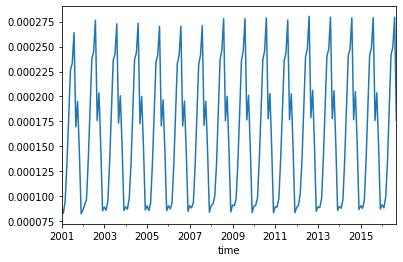

In [80]:
predictions.plot()

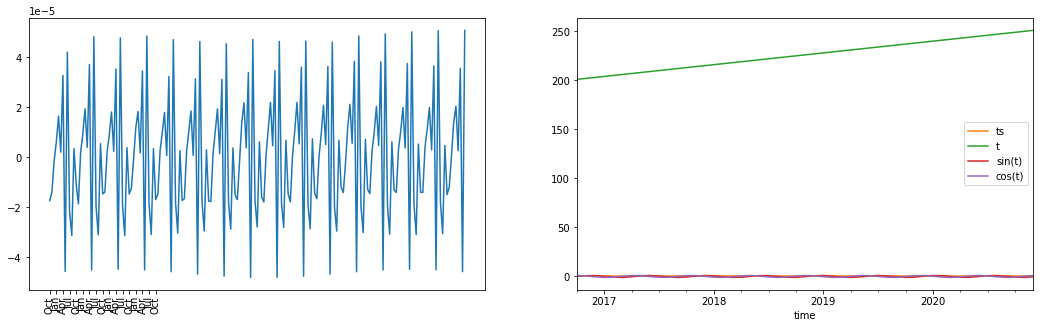

In [77]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,5))

indices = np.arange(0, len(test_data), 3)
ticks = [date.strftime('%b') for date in test_data['ts'].index]
axs[0].set_xticks(indices)
axs[0].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[0].plot(errors)

pd.Series(predictions, index=test_data['ts'].index).plot(ax=axs[1])
test_data.plot(ax=axs[1])
plt.show()

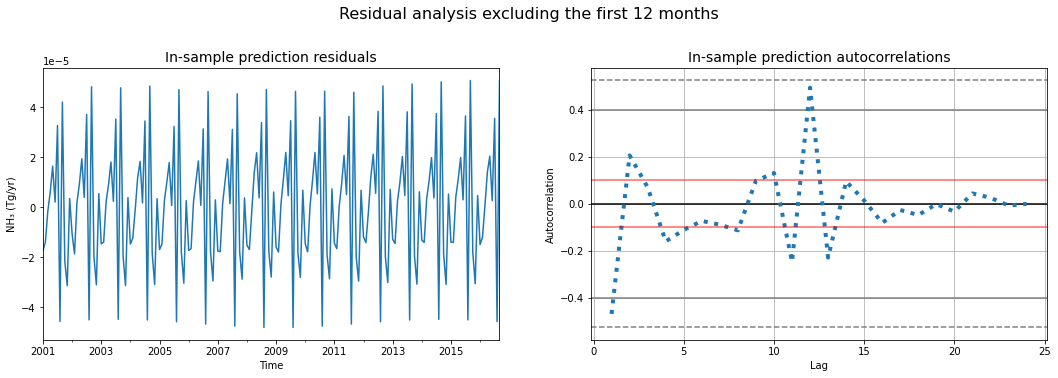

In [78]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,5))
fig.suptitle('Residual analysis excluding the first 12 months', fontsize=16,  y=1.05)

pd.Series(errors, index=predictions.index).plot(ax=axs[0])
axs[0].set_title('In-sample prediction residuals', fontsize=14)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('NH3 (Tg/yr)'.translate(to_pedix))

autocorrelation_plot(errors[:24], ax=axs[1], linestyle='dotted', linewidth=4)
axs[1].set_title('In-sample prediction autocorrelations', fontsize=14)

axs[1].axhline(y=-0.1, color='r', linestyle='-', alpha=.6)
axs[1].axhline(y=0.1, color='r', linestyle='-', alpha=.6)

plt.show()